In [18]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.io
from scipy import signal

import itertools

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, kpss

from pmdarima.arima import auto_arima

from random import sample
from tqdm import tqdm
import pickle
from sklearn.metrics import mean_squared_error

In [7]:
mat = scipy.io.loadmat('PowerValuesOctMay.mat')
m = mat['MeasurementsTotal']

In [8]:
m = np.squeeze(m)

# Data Exploration

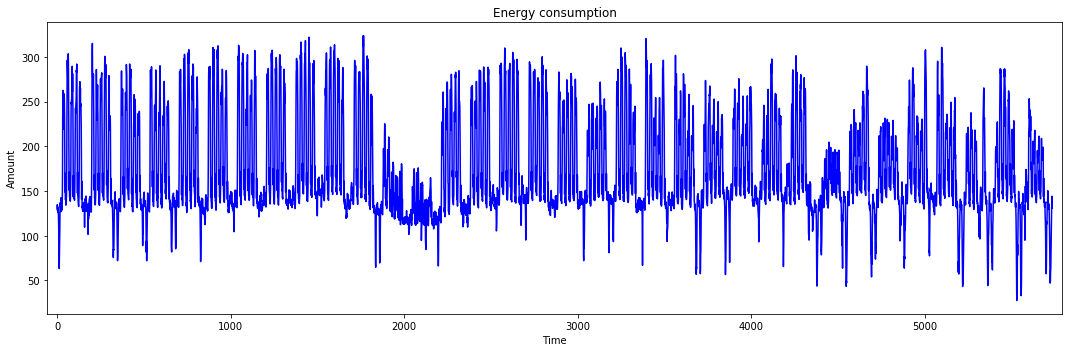

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m, c='b')
ax.set_title('Energy consumption')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_complete_data.png', dpi=300)
plt.show()

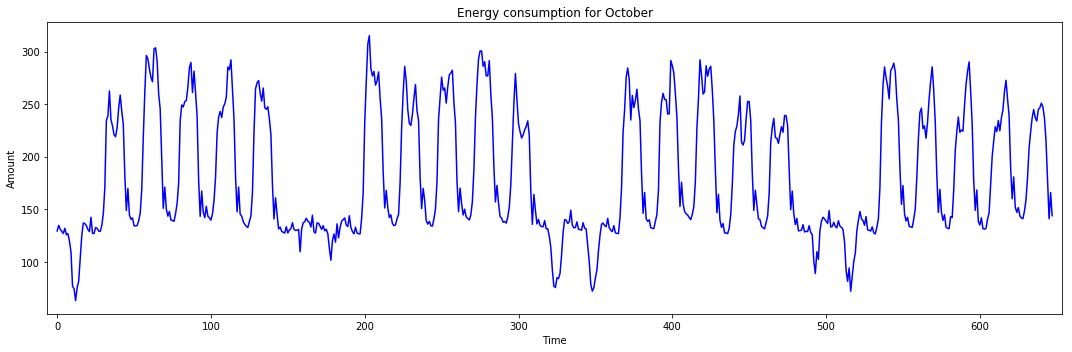

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(m[:27*24], c='b')
ax.set_title('Energy consumption for October')
ax.set_xlabel('Time')
ax.set_ylabel('Amount')
ax.margins(x=0.01)
plt.tight_layout()
plt.savefig('p1_october_data.png', dpi=300)
plt.show()

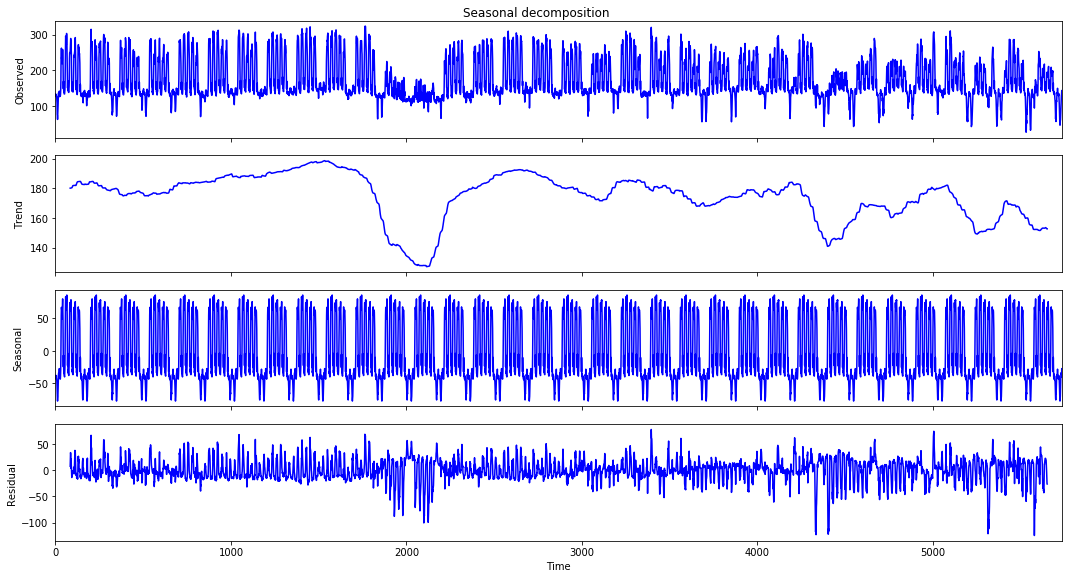

In [11]:
matplotlib.rcParams['figure.figsize'] = [15.0, 8.0]

sd = seasonal_decompose(m, model='additive', freq=168)


fig = sd.plot()
fig.suptitle('Seasonal decomposition', y=1.0)
plt.tight_layout()
plt.savefig('p1_decomposition.png', dpi=300)
plt.show()

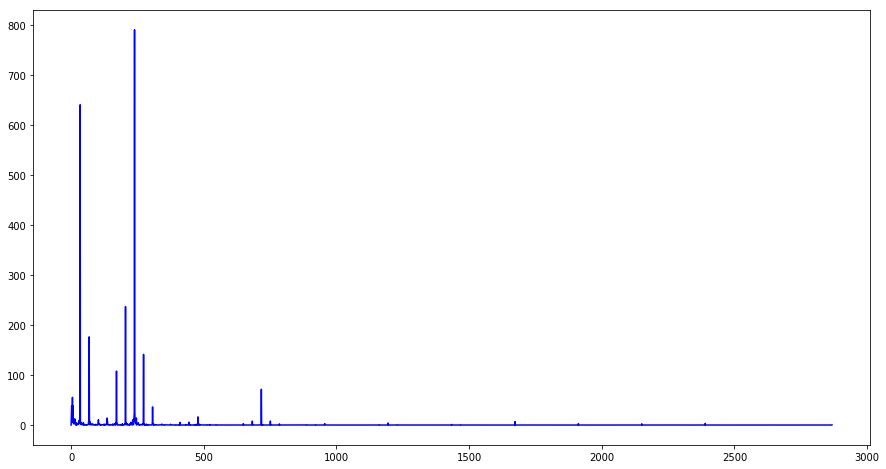

In [12]:
f, Pxx = signal.periodogram(m, scaling='spectrum')
plt.plot(Pxx)

In [13]:
tmp = Pxx.copy()
tmp.sort()
max_values = tmp[-2:]
max_freqs = [list(Pxx).index(v) for v in max_values]
print('Freq1: {:.2f} Freq2: {:.2f}'.format(1/max_freqs[1]*len(m), 1/max_freqs[0]*len(m)))

Freq1: 24.00 Freq2: 168.71


# Model fitting

## Split data in train and test samples

In [14]:
ratio_test = 0.1
num_samples = len(m)
index_split = int(num_samples*(1-ratio_test))
train = m[:index_split]
test = m[index_split:]
print('We have {} samples for training and {} samples for testing.'.format(len(train), len(test)))

We have 5162 samples for training and 574 samples for testing.


## Differencing filter

In [15]:
def apply_differencing_filter(ts, lag):
    num_samples = len(ts)
    return ts[lag:num_samples] - ts[:num_samples-lag]
def apply_differencing_filters(ts, lags):
    for lag in lags:
        ts = apply_differencing_filter(ts, lag)
    return ts

[(1,), (24,), (168,), (1, 24), (1, 168), (24, 168), (1, 24, 168)]


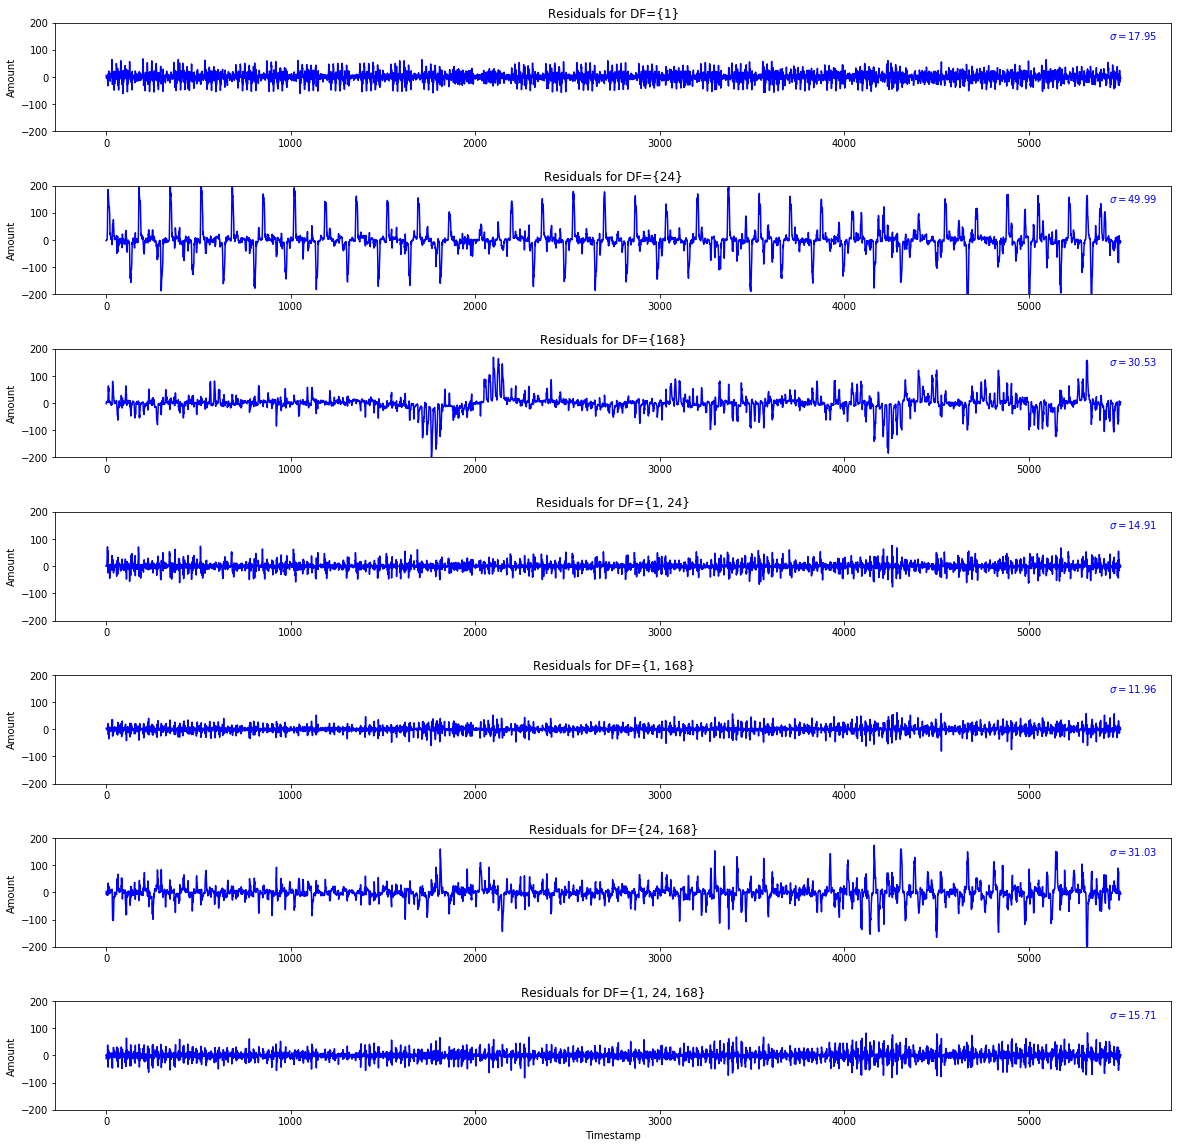

In [8]:
lags = [1, 24, 168]
combinations = []
for l in range(1,len(lags)+1):
    combinations.extend(list(itertools.combinations(lags, l)))
print(combinations)
m_diff = m
thres = 5500
fig, ax = plt.subplots(len(combinations), 1, figsize=(20,20))
plt.subplots_adjust(hspace = 0.5)
for i, lags in enumerate(combinations):
    
    m_diff = apply_differencing_filters(m, lags)[:thres]
    mean = np.mean(m_diff)
    std = np.std(m_diff)
    
    ax[i].text(5700, 130, r'$\sigma=${:.2f}'.format(std), ha='right', va='bottom', color='b')
    ax[i].plot(m_diff, c='b')
    ax[i].set_ylabel('Amount')
    ax[i].set_ylim([-200,200])
    if len(lags) == 1:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-2]))
    else:
        ax[i].set_title('Residuals for DF={{{}}}'.format(str(lags)[1:-1]))
ax[-1].set_xlabel('Timestamp')
#plt.tight_layout()
#plt.savefig('data.png', dpi=300)
plt.show()

In [16]:
def plot_predictions_old(model, test):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    ax.scatter(np.arange(len(test)), test, marker='o', facecolors='None', edgecolors='b')
    ax.plot(test, color='b', linewidth=0.5, label='target')
    ax.plot(model.predict(len(test)), c='r', label='prediction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amount')
    plt.legend()
    #plt.tight_layout()
    #plt.savefig('data.png', dpi=300)
    plt.show()
    
def plot_predictions(residuals, model, train, test, num_obs):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    # prepare array for plots
    x = np.arange(num_obs)
    
    # get the confidence intervals
    predictions, confidence_intervals = get_preds_and_cis(residuals, model, train, test, num_obs)
    lower_bounds, upper_bounds = list(zip(*confidence_intervals))
    
    # plot target prediction
    ax.scatter(x, test[:num_obs], marker='o', facecolors='None', edgecolors='b')
    ax.plot(test[:num_obs], color='b', linewidth=0.5, label='target')
    
    #plot predictions
    ax.plot(predictions, c='r', label='prediction')
    ax.fill_between(x, lower_bounds, upper_bounds, color='r', alpha=0.3, label='95% level')
    
    # plot details
    ax.set_xlabel('Time')
    ax.set_ylabel('Amount')
    plt.legend()
    #plt.tight_layout()
    #plt.savefig('data.png', dpi=300)
    plt.show()
    
def plot_residual_analysis(residuals):
    
    fig = plt.figure(figsize=(15, 8))
    grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.2)
    res_part = fig.add_subplot(grid[0, :])
    acf_part = fig.add_subplot(grid[1, 0])
    pacf_part = fig.add_subplot(grid[1, 1])
    
    res_part.plot(residuals)
    res_part.set_xlabel('Time')
    res_part.set_title('Residuals')
    plot_acf(residuals, acf_part, 170)
    acf_part.set_xlabel('Lag')
    plot_pacf(residuals, pacf_part, 170)
    pacf_part.set_xlabel('Lag')
    plt.tight_layout()
    plt.show()
    
def save(data, name):   
    with open('{}.pkl'.format(name),'wb') as f:
      pickle.dump(data,f)

def load(name):
    with open('{}.pkl'.format(name),'rb') as f:
      data = pickle.load(f)
    return data

def get_preds_and_cis(residuals, model, train, test, num_obs):
    confidence_intervals = []
    predictions = model.predict(model.params, start=len(train), end=len(train)+num_obs-1)
    for i, prediction in enumerate(tqdm(predictions)):
        conf_inter = get_ci(prediction, residuals, i)
        confidence_intervals.append(conf_inter)
    return predictions, confidence_intervals
    
def get_ci(prediction, residuals, offset, num_samples=999, level=0.95):
    lower_bound = int(np.floor((num_samples+1)*(1-level)/2))
    upper_bound = int(np.ceil((num_samples+1)*(1-((1-level)/2))))
    predictions = []
    for i in range(num_samples):
        random_sel = sample(list(residuals), 1)
        random_residual = sum(random_sel)
        #print(random_sel, random_residual)
        predictions.append(prediction+random_residual)
    predictions.sort()
    
    return predictions[lower_bound], predictions[upper_bound]

## Stationarity test

In [12]:
adfuller(m)

(-9.039564649824072,
 5.177561744534966e-15,
 34,
 5701,
 {'1%': -3.431497561276917,
  '5%': -2.8620471117187636,
  '10%': -2.567039933822237},
 44511.09169719046)

In [13]:
kpss(m)

(0.7046431174314702,
 0.013123352960775433,
 34,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Exponential Smoothing

### Without seasonal component

In [ ]:
"""hw_model = ExponentialSmoothing(train)
hw_res = hw_model.fit()

save(hw_model, 'hw_model')
save(hw_res, 'hw_res')"""

100%|██████████| 168/168 [01:06<00:00,  2.23it/s]


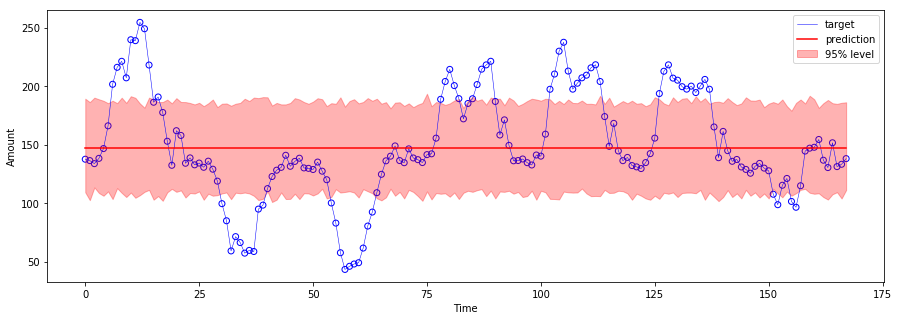

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


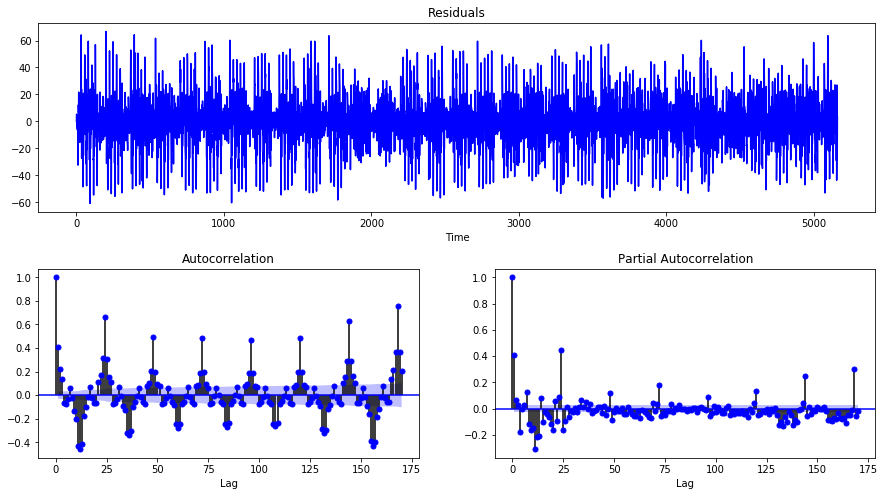

In [220]:
hw_model = load('hw_model')
hw_res = load('hw_res')

plot_predictions(hw_res.resid, hw_model, train, test, 168)
plot_residual_analysis(hw_res.resid)

In [29]:
hw_model = load('hw_model')
hw_res = load('hw_res')
hw_preds = hw_model.predict(hw_model.params, start=len(train), end=len(train)+len(test)-1)
mean_squared_error(hw_preds, test)

2637.5363097232366

In [32]:
hw_res.resid

array([  0.        ,   5.39279784,  -3.77479078, ...,  -9.69384557,
       -19.6696978 ,   3.62172545])

In [31]:
residuals_squared

[0.0,
 29.082268503061467,
 14.24904544930656,
 4.125593363824732,
 3.6177750101436708,
 24.048255821221083,
 37.93577131171649,
 1.087663968038955,
 49.61534023252662,
 108.3810697164693,
 1050.3870425687753,
 6.371049257572469,
 125.32826151658541,
 150.57968318104582,
 37.50136025521499,
 472.4932153200249,
 457.73621228580265,
 147.74276477047033,
 0.2653012035150533,
 3.545928529277591,
 14.504243988949286,
 3.594196787642134,
 186.02010204643048,
 239.33944850146818,
 0.009403340915272377,
 30.83418882918114,
 0.5760916120105776,
 6.407649842176636,
 0.13693961192641796,
 27.328893751452362,
 128.62027272223415,
 619.798161002756,
 4116.155595431141,
 15.937592504617404,
 572.2133630820464,
 747.5247359706545,
 35.552800574229,
 69.49844244507301,
 3.3850394612857486,
 71.77101707637676,
 347.1663424020501,
 156.41478575264952,
 225.42106368522514,
 158.2813079178668,
 2347.1678515958156,
 1135.448411025779,
 434.88456435723225,
 637.9538794700543,
 16.54542913980666,
 1.86797769

In [30]:
residuals_squared = [residual**2 for residual in hw_res.resid]
np.mean(residuals_squared)

326.80840217788676

### With seasonal component

In [ ]:
"""hw_seasonal_model = ExponentialSmoothing(train, trend='add', damped=True, seasonal='add', seasonal_periods=168)
hw_seasonal_res = hw_seasonal_model.fit()

save(hw_seasonal_model, 'hw_seasonal_model')
save(hw_seasonal_res, 'hw_seasonal_res')"""

100%|██████████| 168/168 [01:05<00:00,  2.41it/s]


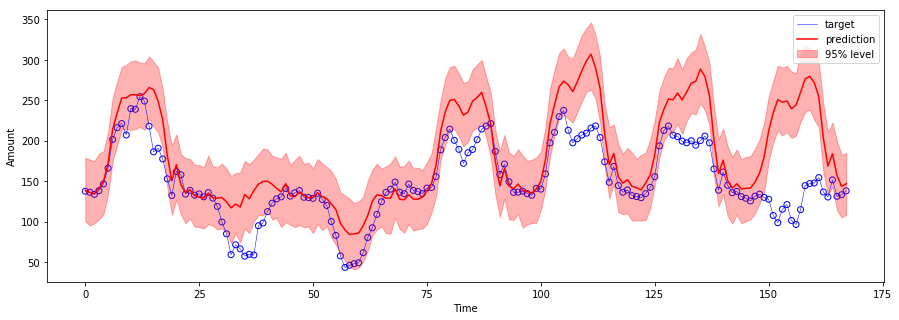

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


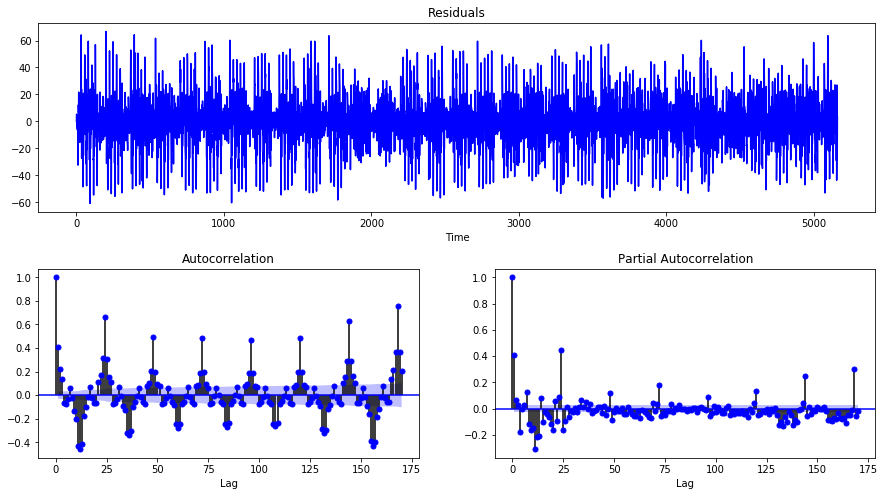

In [219]:
hw_seasonal_model = load('hw_seasonal_model')
hw_seasonal_res = load('hw_seasonal_res')

plot_predictions(hw_model_res.resid, hw_seasonal_model, train, test, 168)
plot_residual_analysis(hw_model_res.resid)

## ARIMA model

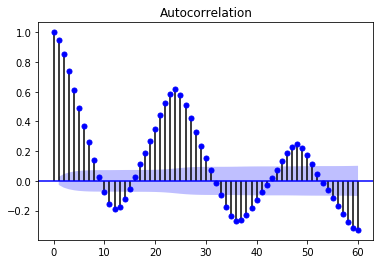

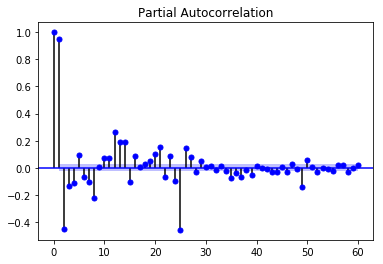

In [230]:
plot_acf(train, lags=60)
plt.show()
plot_pacf(train, lags=60)
plt.show()

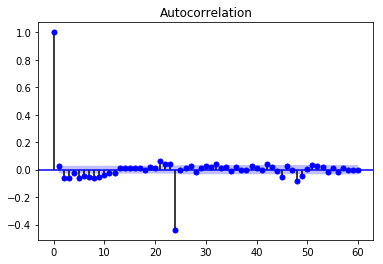

In [228]:
train_diff = apply_differencing_filters(train, [1,24,168])
plot_acf(train_diff, lags=60)
plt.show()

In [233]:
arma20_model = ARMA(train, (2,0))
arma20_model_res = arma20_model.fit()

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the 

/home/joelmfonseca/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


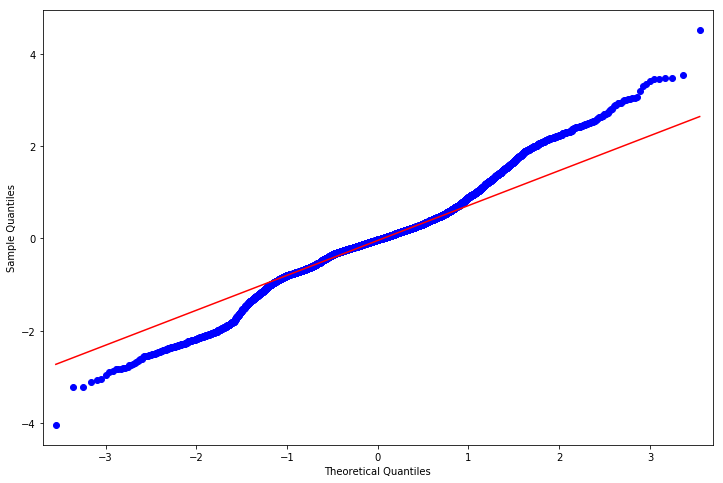

In [238]:
arma20_resid = arma20_model_res.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(arma20_resid, line='q', ax=ax, fit=True)

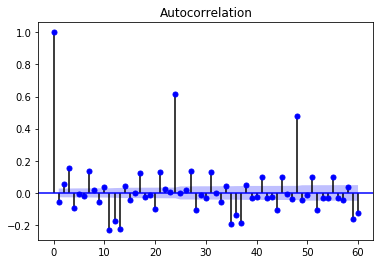

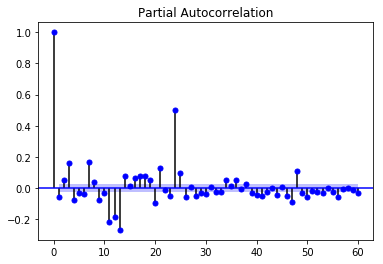

In [240]:
plot_acf(arma20_resid, lags=60)
plt.show()
plot_pacf(arma20_resid, lags=60)
plt.show()

In [ ]:
model_6 = auto_arima(train, start_p=169, start_q=0, max_p=180, max_q=10, max_order=200, stationary=True, trace=True, error_action='ignore',
                   suppress_warnings=True, stepwise=True)

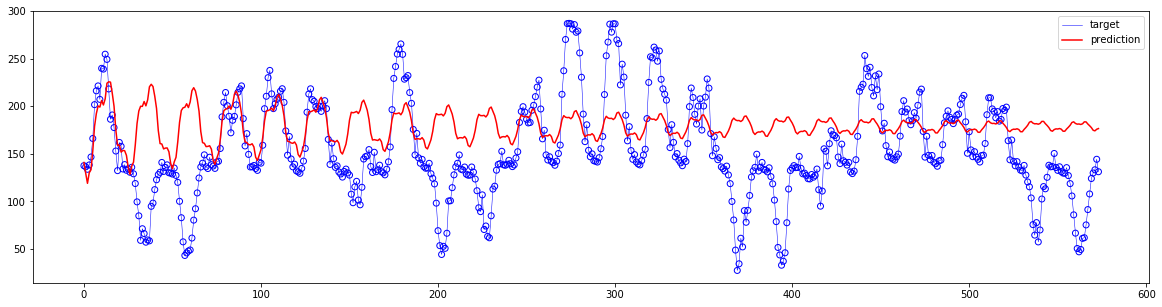

In [54]:
plot_prediction(model_6, test)